# Read, clean, and validate

## DataFrames and Series


### Exploring the NSFG data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
nsfg = pd.read_hdf('nsfg.hdf5', 'nsfg')

In [3]:
# Display the number of rows and columns
print(nsfg.shape)

# Display the names of the columns
print(nsfg.columns)

# Select columns birthwgt_oz1: ounces
ounces = nsfg['birthwgt_oz1']

# Print the first 5 elements of ounces
print(ounces.head(5))

(9358, 10)
Index(['caseid', 'outcome', 'birthwgt_lb1', 'birthwgt_oz1', 'prglngth',
       'nbrnaliv', 'agecon', 'agepreg', 'hpagelb', 'wgt2013_2015'],
      dtype='object')
0     4.0
1    12.0
2     4.0
3     NaN
4    13.0
Name: birthwgt_oz1, dtype: float64


## Clean and Validate

### Clean a variable

In [4]:
nsfg['nbrnaliv'].value_counts()

nbrnaliv
1.0    6379
2.0     100
3.0       5
8.0       1
Name: count, dtype: int64

In [5]:
# replace the value 8 with NaN
nsfg['nbrnaliv'].replace([8], np.nan, inplace=True)

# Print the values and their frequencies
print(nsfg['nbrnaliv'].value_counts())

nbrnaliv
1.0    6379
2.0     100
3.0       5
Name: count, dtype: int64


### Compute a variable

In [6]:
nsfg['agecon'].describe()

count    9358.000000
mean     2446.330199
std       579.392363
min       750.000000
25%      1983.000000
50%      2366.000000
75%      2850.000000
max      4350.000000
Name: agecon, dtype: float64

In [7]:
nsfg['agepreg'].describe()

count    9109.000000
mean     2494.934570
std       578.099231
min       825.000000
25%      2041.000000
50%      2416.000000
75%      2900.000000
max      4350.000000
Name: agepreg, dtype: float64

In [8]:
# Select the columns and divide by 100
agecon = nsfg['agecon'] / 100
agepreg = nsfg['agepreg'] / 100

# Compute the difference
preg_length = agepreg - agecon

# Compute summary statistics
print(preg_length.describe())

count    9109.000000
mean        0.552069
std         0.271479
min         0.000000
25%         0.250000
50%         0.670000
75%         0.750000
max         0.920000
dtype: float64


## Filter and visualize

### Make a histogram

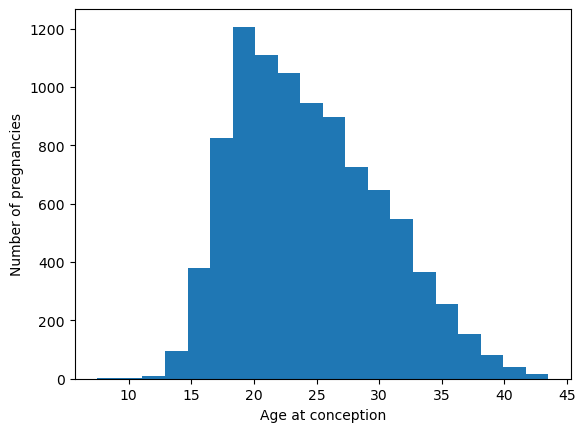

In [10]:
# Plot the histogram
plt.hist(agecon, bins=20)

# Label the axes
plt.xlabel("Age at conception")
plt.ylabel('Number of pregnancies')
plt.savefig('./conception.png')

Text(0, 0.5, 'Number of pregnancies')

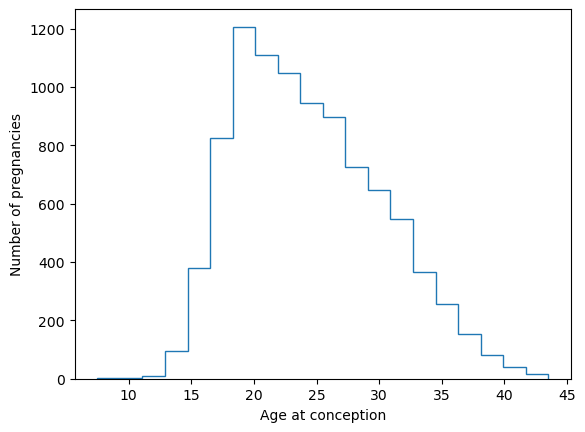

In [11]:
# Plot the histogram
plt.hist(agecon, bins=20, histtype='step')

# Label the axes
plt.xlabel("Age at conception")
plt.ylabel('Number of pregnancies')

### Compute birth weight

In [12]:
def resample_rows_weighted(df, column='wgt2013_2015'):
    """Resamples a DataFrame using probabilities proportional to given column.
    Args:
        df: DataFrame
        column: string column name to use as weights
    returns: 
        DataFrame
    """
    weights = df[column].copy()
    weights /= sum(weights)
    indices = np.random.choice(df.index, len(df), replace=True, p=weights)
    sample = df.loc[indices]
    return sample

In [13]:
# Resample the data
nsfg = resample_rows_weighted(nsfg, 'wgt2013_2015')

# Clean the weight variables
pounds = nsfg['birthwgt_lb1'].replace([98, 99], np.nan)
ounces = nsfg['birthwgt_oz1'].replace([98, 99], np.nan)

# Compute total birth weight
birth_weight = pounds + ounces/16

In [14]:
# Create a Boolean Series for full-term babies
full_term = nsfg['prglngth'] >= 37

# Select the weights of full-term babies
full_term_weight = birth_weight[full_term]

# Compute the mean weight of full-term babies
print(full_term_weight.mean())

7.422921529897648


### Filter

In [15]:
# Filter full-term babies
full_term = nsfg['prglngth'] >= 37

# Filter single birth
single = nsfg['nbrnaliv'] == 1

# Compute birth weight for single full-term babies
single_full_term_weight = birth_weight[single & full_term]
print('Single full-term mean:', single_full_term_weight.mean())

# Compute birth weight for multiple full-term babies
mult_full_term_weight = birth_weight[~single & full_term]
print('Multiple full-term mean:', mult_full_term_weight.mean())

Single full-term mean: 7.431417027807873
Multiple full-term mean: 5.905241935483871
